In [1]:
import json
from pathlib import Path

import geopandas

In [11]:
data_path = Path('../data')

In [15]:
cafes_filename = data_path / 'osm-amenity-cafe-london.geojson'
cycle_hire_filename = data_path / 'cycle_hire.gpkg'

In [56]:
cycle_hires = geopandas.read_file(cycle_hire_filename)
cycle_hires.head(2)

,id,name,area,nbikes,nempty,geometry
0,1,River Street,Clerkenwell,4,14,POINT (-0.10997 51.52916)
1,2,Phillimore Gardens,Kensington,2,34,POINT (-0.19757 51.49961)


In [28]:
with open(cafes_filename, 'r') as fh:
    cafes_data = json.load(fh)
cafes_data['features'][0]

{'type': 'Feature',
 'properties': {'@id': 'node/25475389',
  'amenity': 'cafe',
  'fixme': 'not on FHRS',
  'name': 'Woburn Cafe'},
 'geometry': {'type': 'Point', 'coordinates': [-0.1292505, 51.5265807]},
 'id': 'node/25475389'}

In [33]:
with open(cafes_filename, 'r') as fh:
    cafes_data = json.load(fh)
    cafes_features = []
    for feature in cafes_data['features']:
        cafe = {
            'type': 'Feature',
            'properties': {},
            'geometry': feature['geometry']
        }
        props = feature['properties']
        if '@id' in props:
            cafe['properties']['osm_id'] = props['@id']
        else:
            cafe['properties']['osm_id'] = None
        if 'name' in props:
            cafe['properties']['name'] = props['name']
        else:
            cafe['properties']['name'] = ''
        cafes_features.append(cafe)
cafes = geopandas.GeoDataFrame.from_features(cafes_features, crs=4326)

In [30]:
cafes.head(2)

,geometry,osm_id,name
0,POINT (-0.12925 51.52658),node/25475389,Woburn Cafe
1,POINT (-0.11611 51.52476),node/25497832,Cafe Angel


In [34]:
geopandas.sjoin_nearest(cycle_hires, cafes)

/home/mert2014/micromamba/envs/geocompy/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,id,name_left,area,nbikes,nempty,geometry,index_right,osm_id,name_right
0,1,River Street,Clerkenwell,4,14,POINT (-0.10997 51.52916),486,node/1343966881,Ground Control
1,2,Phillimore Gardens,Kensington,2,34,POINT (-0.19757 51.49961),907,node/3447385082,Phillies Cafe
2,3,Christopher Street,Liverpool Street,0,32,POINT (-0.08461 51.52128),499,node/1448311257,Starbucks
3,4,St. Chad's Street,King's Cross,4,19,POINT (-0.12097 51.53006),170,node/430437717,Cafe Plaka
4,5,Sedding Street,Sloane Square,15,12,POINT (-0.15688 51.49313),2912,node/11016510688,Vita cafe
...,...,...,...,...,...,...,...,...,...
737,773,Tallis Street,Temple,0,23,POINT (-0.10735 51.51189),1279,node/4661317159,Hilliard
738,774,Hurlingham Park,Parsons Green,11,9,POINT (-0.20464 51.47013),3010,node/11224897987,Hally's
739,775,Little Brook Green,Brook Green,16,17,POINT (-0.22387 51.49666),2397,node/9033769859,Brook Brown
740,776,Abyssinia Close,Clapham Junction,10,10,POINT (-0.16703 51.46033),973,node/3667302483,2Love Tea & Coffee House


<Axes: >

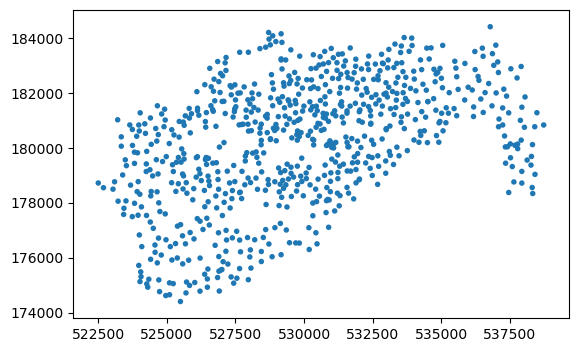

In [46]:
cycle_hires_100m = cycle_hires.to_crs(27700).copy()
cycle_hires_100m.geometry = cycle_hires_100m.buffer(100)
cycle_hires_100m.plot()

In [50]:
cafes_within_100m = geopandas.sjoin(cycle_hires_100m, cafes.to_crs(27700), how="left", predicate="intersects").groupby("id").agg({
    "index_right": "count",
}).rename(columns={"index_right": "cafes_within_100m"})

<Axes: >

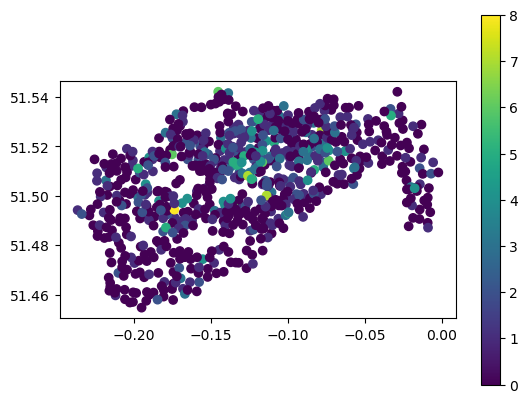

In [58]:
cycle_hires_near_cafes = cycle_hires.set_index("id").join(cafes_within_100m)
cycle_hires_near_cafes.plot(column="cafes_within_100m", legend=True)

In [60]:
cycle_hires_near_cafes.sort_values(by="cafes_within_100m").tail()

,name,area,nbikes,nempty,geometry,cafes_within_100m
id,,,,,,
115,Braham Street,Aldgate,1,31,POINT (-0.07354 51.51423),6
347,Lower Marsh,Waterloo,7,10,POINT (-0.11394 51.50014),7
39,Shoreditch High Street,Shoreditch,23,17,POINT (-0.07813 51.52638),7
341,Craven Street,Strand,10,11,POINT (-0.12602 51.50810),7
356,South Kensington Station,South Kensington,7,8,POINT (-0.17388 51.49441),8
